In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 21 14:07:06 2021

@author: akh
"""
import pandas as pd
from htMOD import AKH_HT as HT
from sklearn.preprocessing import scale
import numpy as np 
from clusterMod import *
import matplotlib.pyplot as plt
from plotmod import plotlines, labelcolors, plotbyAngle, BA_HT, HThist
from examineMod import examineClusters
import seaborn as sns
from jitteringHTcenter import moveHTcenter, rotateHT
from matplotlib import cm

# def fragmentDikes(df, maxL=20000, ndikesMax=None, distortion=0):
#     np.random.seed(5)
#     dfFrag=pd.DataFrame(columns=df.columns)
#     ndikes=0
#     if ndikesMax is None: 
#         ndikesMax=2000
        
       
#     for i in range(len(df)):
#         nSegments=np.random.randint(3)
#         if ndikes < ndikesMax: 
#             for j in range(nSegments):
#                 high=max(0, df['Xend'].iloc[i])
#                 low=min(0, df['Xend'].iloc[i])
#                 xrange=np.random.randint(low,high, size=2)
#                 m=df['Slope'].iloc[i]*(1+np.random.rand()*distortion)
#                 yrange=m*xrange
                
#                 L=np.sqrt((xrange[0]-xrange[1])**2+(yrange[0]-yrange[1])**2)
#                 if L > maxL: 
#                     continue
                
#                 if max(abs(yrange)) > df['Yend'].max() :
#                     continue 
#                 dfFrag=dfFrag.append(pd.DataFrame({'Xstart':xrange[0], 'Xend': xrange[1], 
#                                                    'Ystart': yrange[0], 'Yend':yrange[1], 
#                                                    'Slope':m, 'Length':L
#                                                        }, index=[0]), ignore_index=True)
#                 ndikes=ndikes+1
                
#     # a=np.full(len(dfFrag), False)
#     # a[:int(len(dfFrag)/mask)]=True 
#     # np.random.shuffle(a)
#     # dfFrag=dfFrag.iloc[a]
    
    
#     return dfFrag 


def makeRadialSwarm(radius, doubled=True, anglestart=-90, anglestop=90, ndikes=50, center=[0,0]):
    
    #center=np.array([0,0])
    angles=np.linspace(anglestart, anglestop, ndikes)
    m=np.tan(np.deg2rad(angles))
    
    Xstart=np.zeros(ndikes)+center[0]
    Ystart=np.zeros(ndikes)+center[1]
    Xend=radius/np.sqrt(1+m**2)+center[0]
    Yend=Xend*m+center[1]
    
    if doubled:
        
        Xstart=np.append(Xstart, np.zeros(ndikes)+center[0])
        Ystart=np.append(Ystart, np.zeros(ndikes)+center[1])
        Yend=np.append(Yend, -1*Xend*m+center[1])
        Xend=np.append(Xend, -1*radius/np.sqrt(1+m**2)+center[0])
        
        
    Xstart[abs(Xstart)<10**-6]=1
    print(center)
    return Xstart, Ystart, Xend, Yend

def makeRadialSwarmdf(radius, doubled=True, anglestart=-90, anglestop=90, ndikes=50, center=[0,0]):
    
    #center=np.array([0,0])
    angles=np.linspace(anglestart, anglestop, ndikes)
    m=np.tan(np.deg2rad(angles))
    
    Xstart=np.zeros(ndikes)+center[0]
    Ystart=np.zeros(ndikes)+center[1]
    Xend=radius/np.sqrt(1+m**2)+center[0]
    Yend=Xend*m+center[1]
    
    if doubled:
        
        Xstart=np.append(Xstart, np.zeros(ndikes)+center[0])
        Ystart=np.append(Ystart, np.zeros(ndikes)+center[1])
        Yend=np.append(Yend, -1*Xend*m+center[1])
        Xend=np.append(Xend, -1*radius/np.sqrt(1+m**2)+center[0])
        
        
    Xstart[abs(Xstart)<10**-6]=1
    
    df=pd.DataFrame({'Xstart':Xstart, 'Xend': Xend, 'Ystart': Ystart, 'Yend':Yend})
                     
    return df

def addSwarms(dflist):
    dfSwarm=pd.DataFrame()
    b=0
    for i in dflist:
        i['label']=[b]*len(i)
        dfSwarm=dfSwarm.append(i)
        b=b+1
        
    return dfSwarm

def makeLinearSwarm(length, slope,  ndikes=20):
    
    Xstart=np.linspace(-1*length,length, ndikes)
    b=np.random.rand(ndikes)*2*length
    Ystart=Xstart*slope+b
    Xend=Xstart+length/np.sqrt(1+slope**2)
    Yend=Xend*slope+b 
    
    
    return Xstart, Ystart, Xend, Yend

# make linear dike swarms of angle and rho distributions 
def makeLinear2(length, angle, angleSTD, rho, rhoSTD, ndikes=100):
    angles=np.random.normal(angle, angleSTD, ndikes)
    rhos=np.random.normal(rho, rhoSTD, ndikes)

    b=rhos/np.sin(np.deg2rad(angles))
    slopes=-1/np.tan(np.deg2rad(angles))
    Xstart=np.random.normal(rho, rhoSTD, ndikes)
    Ystart=slopes*Xstart+b
    Xend=Xstart-length/np.sqrt(1+slopes**2)
    Yend=slopes*Xend+b

    df=pd.DataFrame({'Xstart':Xstart, 'Xend': Xend, 'Ystart': Ystart, 'Yend':Yend})

    return df, angles, rhos


def makeLinearSwarmdf(length, angle, rho=0, ndikes=20, angleSTD=1, rhoSTD=10000):
    
    
    angles=np.random.normal(angle, angleSTD, ndikes)
    slopes=-1/np.tan(np.deg2rad(angles))
    Xstart= (3*length)*np.random.random_sample(ndikes) + 2*length#np.linspace(-1*length,length, ndikes)  
    b=np.random.normal(rho, rhoSTD, ndikes)*np.sin(np.deg2rad(angles))
    
    Ystart=Xstart*slopes+b
    Xend=Xstart-length**2/(1+slopes**2)
    Yend=Xend*slopes+b 
    
    df=pd.DataFrame({'Xstart':Xstart, 'Xend': Xend, 'Ystart': Ystart, 'Yend':Yend})
                     
    return df


def OverLappingSwarms(nlinear, nradial, A1,A2, slope, center):
    length=45000
    
    X1, Y1, X2, Y2=makeRadialSwarm(length, doubled=False, anglestart=A1, anglestop=A2, ndikes=nradial, center=center)
    X3, Y3, X4, Y4=makeLinearSwarm(length,slope,ndikes=nlinear)
    Xstart=np.append(X1,X3)
    Ystart=np.append(Y1,Y3)
    
    Xend=np.append(X2,X4)
    Yend=np.append(Y2,Y4)
    
    #print(len(Xstart), len(Ystart))
    
    iddike=np.arange(0, len(Xstart))
    dlength=np.sqrt( (Xstart-Xend)**2 + (Ystart-Yend)**2)
    reg=np.ones(len(X1))
    
    reg=np.append(reg, np.zeros(nlinear))
    """ Regime label, 1 for radial 0 for linear"""
    #print(len(iddike), len(reg), len(dlength))
    df=pd.DataFrame({'Xstart':Xstart, 'Xend': Xend, 'Ystart': Ystart, 'Yend':Yend, 'ID': iddike, 'seg_length':dlength, 'Regime': reg})


    return df

def ManyRadial(nradial):
    length=5000
    ndikes=50
    
    Xstart, Ystart, Xend, Yend=makeRadialSwarm(length, doubled=True, anglestart=30, anglestop=90, ndikes=ndikes, center=[0,0])
    
    for i in range(nradial-1):
        center= [5000*(i+1),5000*(i+1)]
        X1=Xstart+center[0]
        Y1=Ystart+center[1]
        X2=Xend+center[0]
        Y2=Yend+center[1]
        print(center)
        Xstart=np.append(Xstart,X1)
        Ystart=np.append(Ystart,Y1)
    
        Xend=np.append(Xend,X2)
        Yend=np.append(Yend,Y2)

    
    #print(len(Xstart), len(Ystart))
    
    iddike=np.arange(0, len(Xstart))
    dlength=np.sqrt( (Xstart-Xend)**2 + (Ystart-Yend)**2)

    """ Regime label, 1 for radial 0 for linear"""
    #print(len(iddike), len(reg), len(dlength))
    df=pd.DataFrame({'Xstart':Xstart, 'Xend': Xend, 'Ystart': Ystart, 'Yend':Yend, 'ID': iddike, 'seg_length':dlength})


    return df

    

def fragmentDikes(df):
    m=(df['Ystart']-df['Yend'])/(df['Xstart']-df['Xend'])
    df['Slope']=m
    bint=df['Ystart']-m*df['Xstart']
    dfFrag=pd.DataFrame()
    print(len(m), len(bint))
    for i in range(len(df)):
        nSegments=np.random.randint(2,7)
        high=max(df['Xend'].iloc[i], df['Xstart'].iloc[i])
        low=min(df['Xend'].iloc[i], df['Xstart'].iloc[i])
        xrange1=np.random.randint(low,high, size=nSegments)
        xrange2=np.random.randint(low,high, size=nSegments)
        m2=(m[i]+np.random.rand()*np.deg2rad(10))

        yrange1=m2*xrange1+bint[i]
        yrange2=m2*xrange2+bint[i]
        L=np.sqrt((xrange1-xrange2)**2+(yrange1-yrange2)**2)

        dfFrag=dfFrag.append(pd.DataFrame({'Xstart':xrange1, 'Xend': xrange2, 
                                           'Ystart': yrange1, 'Yend':yrange2,
                                           'Length':L
                                               }), ignore_index=True)
    return dfFrag


mean 30.072193526122867 std 2.052007089260132
mean 15887.349765951349 std 516045.70392379886
0 0


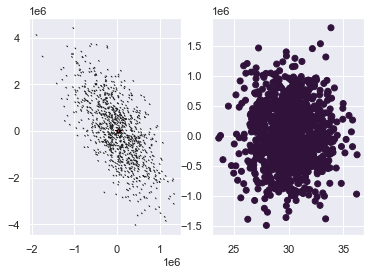

In [20]:

radius=39000
df1=makeRadialSwarmdf(radius, doubled=False, anglestart=-90, anglestop=90, ndikes=200, center=[0,0])
df2=makeRadialSwarmdf(radius, doubled=False, anglestart=-40, anglestop=40, ndikes=200, center=[40000,40000])
df3=makeRadialSwarmdf(radius, doubled=False, anglestart=-20, anglestop=50, ndikes=200, center=[-100000,100000])
df4=makeRadialSwarmdf(radius, doubled=False, anglestart=-10, anglestop=20, ndikes=200, center=[200000,-300000])
df5=makeRadialSwarmdf(radius, doubled=False, anglestart=-10, anglestop=15, ndikes=200, center=[10000,500000])
#df6=makeLinearSwarmdf(radius, 2, rho=500000, ndikes=1000, angleSTD=10, rhoSTD=20000)
df6, theta1, rho1=makeLinear2(radius, 6, 34, 3200, 50000, ndikes=4000)
df=addSwarms([df1,df2,df3,df4,df5, df6])

lines=df6
fig,ax=plt.subplots(1,2)
plotlines(df6, 'k', ax[0], center=True)
theta, rho, xc, yc= HT(lines, yc=0, xc=0)
lines['AvgRho']=rho
lines['AvgTheta']=theta
print("mean",np.mean(theta), "std", np.std(theta) )
print("mean",np.mean(rho), "std", np.std(rho) )
print( np.sum(theta-theta1>1), np.sum(rho-rho1 >1))
ax[1].scatter(theta,rho, c=lines['label'], cmap=cm.turbo)

#ax[1].set_xlim([-90,90])
df.to_csv('/home/akh/myprojects/Linking-and-Clustering-Dikes/syntheticRadial_testfindRadial_doubledFalse.csv')
